<a href="https://colab.research.google.com/github/dnjswngo/artificial-intelligence-programming/blob/master/230103.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 한국어 및 영어의 언어형태학적 차이
자연언어는 언어형태학적으로 크게 세 종류로 구분됨

1.   고립어: 한자를 사용하는 중국어와 같이 단어의 형태가 시제, 인칭 변화 등에 따라 바뀌지 않고 고정된 형태의 언어
2.   굴절어: 영어, 독일어 등과 같이 시제, 인칭 변화 등에 따라 단어의 형태가 변하는 언어
3.   교착어: 한국어, 일본어 등과 같이 단어에 어미가 붙어 시제, 인칭 등의 뜻이 최종 결정되는 언어

## 한국어 텍스트 토큰화의 어려움
띄어쓰기로 split해서 토큰화하면 단어랑 조사가 붙어있어서 같은 의미라도 조사가 다르면 서로 다른 단어로 인식하게됨(그가 그에게 그는 그를)

띄어쓰기가 잘 지켜지지 않는 corpus도 많아서 기본적인 split방식으로는 만족스러운 토큰 얻기 어려움

##형태소 분석기
자립형태소, 의존 형태소 단위로 분리하면 의미에 기반한 각 토큰을 얻을 수 있고 너무 자주 사용되는 의존 형태소 등은 불용어로 제거할 수도 있음

KoNLPy가 가장 널리 쓰이는 형태소 분석기 라이브러리

카카오에서 공개한 딥러닝 기반 형태소 분석기 khaii



In [4]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 717 kB/s 
     |████████████████████████████████| 465 kB 76.4 MB/s 


In [5]:
"""
Okt(open korean text): ㅋㅋ, ㄴㄴ 같은 인터넷 용어들도 분석 가능
Kkma: 꼬꼬마 형태소 분석기. 어미분석 자세하게 수행
Mecab: 일본어 형태소 분석기를 한국어 버전으로 구현한 것
"""
from konlpy.tag import Okt
okt=Okt()
print('Okt 형태소 분석: ', okt.morphs("한국어 단어는 형태소들로 구성되어 있다."))#moprhs는 형태소 분석
print('Okt 품사 태깅: ', okt.pos("한국어 단어는 형태소들로 구성되어 있다.")) #얜 품사 태깅

Okt 형태소 분석:  ['한국어', '단어', '는', '형태소', '들', '로', '구성', '되어', '있다', '.']
Okt 품사 태깅:  [('한국어', 'Noun'), ('단어', 'Noun'), ('는', 'Josa'), ('형태소', 'Noun'), ('들', 'Suffix'), ('로', 'Josa'), ('구성', 'Noun'), ('되어', 'Verb'), ('있다', 'Adjective'), ('.', 'Punctuation')]


In [6]:
#형태소 분석기마다 품사코드 조금씩 다르고 이에 따른 형태소 분석 결과 다를 수도 있음
from konlpy.tag import Kkma
kkma=Kkma()
print('Kkma 형태소 분석: ', kkma.morphs("한국어 단어는 형태소들로 구성되어 있다."))#moprhs는 형태소 분석
print('Kkma 품사 태깅: ', kkma.pos("한국어 단어는 형태소들로 구성되어 있다.")) #얜 품사 태깅

Kkma 형태소 분석:  ['한국어', '단어', '는', '형태소', '들', '로', '구성', '되', '어', '있', '다', '.']
Kkma 품사 태깅:  [('한국어', 'NNG'), ('단어', 'NNG'), ('는', 'JX'), ('형태소', 'NNG'), ('들', 'XSN'), ('로', 'NNG'), ('구성', 'NNG'), ('되', 'XSV'), ('어', 'ECD'), ('있', 'VXV'), ('다', 'EFN'), ('.', 'SF')]


In [7]:
#RNN을 이용한 네이버 영화 리뷰 감성 분석
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter

In [8]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7ff60cee88e0>)

In [9]:
train_data=pd.read_table('ratings_train.txt')
test_data=pd.read_table('ratings_test.txt')
print('Train data len: ', len(train_data))
train_data.head()

Train data len:  150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [10]:
print('Test data len: ', len(test_data))
test_data.head()

Test data len:  50000


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [11]:
train_data.drop_duplicates(subset=['document'], inplace=True) #중복데이터 삭제
train_data.groupby('label').size()

label
0    73342
1    72841
dtype: int64

In [12]:
train_data['document']=train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ") #한글 및 공백 이외 제거
train_data.head()

<ipython-input-12-25be7a52d061>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document']=train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ") #한글 및 공백 이외 제거


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [13]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

<ipython-input-13-c2f9538d5bc3>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


id            0
document    790
label         0
dtype: int64


In [14]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [15]:
train_data = train_data.dropna(how = 'any') #null 값 제거
print(len(train_data))

145393


In [16]:
#불용어 정의, 형태소 분석기로 토큰화 하기 ~~
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [17]:
from pandas.core.computation.parsing import tokenize_backtick_quoted_string
okt=Okt()
X_train=[]
for sentence in tqdm(train_data['document']):
  tokenize_sentence=okt.morphs(sentence, stem=True) #토큰화
  stopwords_removed_sentence=[word for word in tokenize_sentence if not word in stopwords] #불용어 제거
  X_train.append(stopwords_removed_sentence)
print(X_train[:3])

100%|██████████| 145393/145393 [06:05<00:00, 398.00it/s]

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [18]:
X_test=[]
for sentence in tqdm(test_data['document']):
  #테스트 데이터는 정제 안됐으니까 string으로 캐스팅 후 토큰화
  tokenized_sentence=okt.morphs(str(sentence), stem=True) 
  stopwords_removed_sentence=[word for word in tokenized_sentence if not word in stopwords]
  X_test.append(stopwords_removed_sentence)

100%|██████████| 50000/50000 [02:10<00:00, 383.28it/s]


In [19]:
def tokenize(x_train, y_train, x_val, y_val):
  word_list=[]

  for sent in x_train:
    for word in sent:
      word_list.append(word)

  corpus= Counter(word_list)
  #sorting on the basis of most commom words
  corpus_=sorted(corpus, key=corpus.get,reverse=True)[:10000]
  #creating a dict
  onehot_dict={w:i+1 for i, w in enumerate(corpus_)} 

  #tokenize
  final_list_train, final_list_test=[],[]
  for sent in x_train:
    final_list_train.append([onehot_dict[word] for word in sent
                             if word in onehot_dict.keys()])
  for sent in x_val:
    final_list_test.append([onehot_dict[word] for word in sent
                             if word in onehot_dict.keys()])
  return np.array(final_list_train), np.array(y_train), np.array(final_list_test), np.array(y_val), onehot_dict

<ipython-input-19-1f2a240a996c>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(y_train), np.array(final_list_test), np.array(y_val), onehot_dict


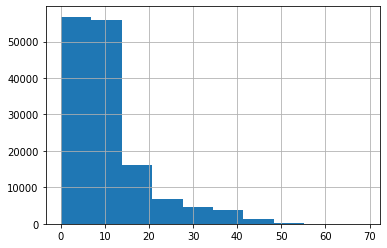

count    145393.000000
mean         10.520954
std           8.676162
min           0.000000
25%           5.000000
50%           8.000000
75%          13.000000
max          69.000000
dtype: float64

In [20]:
#데이터셋 생성 및 문장 길이(단어 단위)에 대한 통계 분석
x_train, y_train, x_test, y_test, vocab=tokenize(X_train, train_data['label'], X_test, test_data['label'])

rev_len=[len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [21]:
#대부분의 문장을 그대로 담을 수 있는 길이 50으로 데이터 padding
def padding_(sentences, seq_len):
  features=np.zeros((len(sentences), seq_len), dtype=int)
  for ii, review in enumerate(sentences):
    if len(review) !=0:
      features[ii, -len(review):]=np.array(review)[:seq_len]
  return features

x_train_pad=padding_(x_train, 50)
x_test_pad=padding_(x_test, 50)

In [22]:
#데이터셋 생성
# create Tensor datasets
train_data = TensorDataset(t.from_numpy(x_train_pad), t.from_numpy(y_train))
test_data = TensorDataset(t.from_numpy(x_test_pad), t.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [23]:
#모델 정의
class GRU_model(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, device):
        super(GRU_model, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.device = device

        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)

    def forward(self, x):
        x = self.embed(x)
        h_0 = self._init_state(batch_size=x.size(0)) # 첫번째 히든 스테이트를 0벡터로 초기화
        x, _ = self.gru(x, h_0)  # GRU의 리턴값은 (배치 크기, 시퀀스 길이, 은닉 상태의 크기)
        h_t = x[:,-1,:] # (배치 크기, 은닉 상태의 크기)의 텐서로 크기가 변경됨. 즉, 마지막 time-step의 은닉 상태만 가져온다.
        logit = self.out(h_t)  # (배치 크기, 은닉 상태의 크기) -> (배치 크기, 출력층의 크기)
        return logit

    def _init_state(self, batch_size):
        new_state = t.zeros(self.n_layers, batch_size, self.hidden_dim).to(self.device)
        return new_state

In [24]:
is_cuda=t.cuda.is_available()
if is_cuda:
  device=t.device('cuda')
  print('GPU is available')
else:
  device=t.device('cpu')
  print("GPU not available, CPU used")

GPU is available


In [25]:
#하이퍼파라미터 설정, 모델 객체생성
n_layers=1
vocab_size=len(vocab)+1
hidden_dim=128
embed_dim=100
n_classes=2

model=GRU_model(n_layers, hidden_dim, vocab_size, embed_dim, n_classes, device).to(device)

In [26]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    train_loss = 0
    for i, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        logit = model(x)
        loss = criterion(logit, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
      
    return train_loss / len(data_loader.dataset)

def evaluate(model, data_loader):
    model.eval()
    corrects, total_loss = 0, 0
    for i, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)

        logit = model(x)
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    size = len(data_loader.dataset)
    
    avg_accuracy = 100.0 * corrects / size
    return avg_accuracy

In [27]:
num_epochs=10
lr=0.001
criterion=nn.CrossEntropyLoss()
optimizer=t.optim.Adam(model.parameters(), lr=lr)

for e in range(1, num_epochs+1):
  train_loss=train(model, criterion, optimizer, train_loader)
  test_accuracy=evaluate(model, test_loader)

  print("[Epoch: %d] train loss : %5.2f | test accuracy : %5.2f" % (e, train_loss, test_accuracy))

[Epoch: 1] train loss :  0.41 | test accuracy : 83.35
[Epoch: 2] train loss :  0.31 | test accuracy : 84.27
[Epoch: 3] train loss :  0.26 | test accuracy : 84.80
[Epoch: 4] train loss :  0.22 | test accuracy : 84.43
[Epoch: 5] train loss :  0.17 | test accuracy : 83.92
[Epoch: 6] train loss :  0.12 | test accuracy : 83.64
[Epoch: 7] train loss :  0.09 | test accuracy : 83.19
[Epoch: 8] train loss :  0.07 | test accuracy : 83.10
[Epoch: 9] train loss :  0.06 | test accuracy : 83.07
[Epoch: 10] train loss :  0.05 | test accuracy : 82.80


그래서 내가 한건


1.   데이터 로드
2.   중복 데이터 제거
3. 정규식 이용한 한글 및 공백 이외 문자 제거
4. NULL 데이터 제거
5.  형태소 분석기를 활용한 토큰화 및 불용어 제거 >> 한국 NLP 특화된 처리
6.  Vocab 생성 및 단어 인덱스 형태의 데이터셋 생성
7.  데이터에 대한 padding 진행
8.  pytorch 데이터셋 생성
9.  모델 정의, 학습 및 테스트 함수 정의
10. 학습, 테스트 진행



In [28]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 14.8 MB/s 
     |████████████████████████████████| 182 kB 75.3 MB/s 
     |████████████████████████████████| 7.6 MB 64.9 MB/s 


In [30]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

train_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 데이터 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 한글 및 공백 이외 제거
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how = 'any')  # null값 제거

test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 한글 및 공백 이외 제거
test_data['document'] = test_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how = 'any')  # null값 제거

<ipython-input-30-8f2c1df43bf0>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 한글 및 공백 이외 제거
<ipython-input-30-8f2c1df43bf0>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
<ipython-input-30-8f2c1df43bf0>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")  # 한글 및 공백 이외 제거
<ipython-input-30-8f2c1df43bf0>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [33]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

#pre-trained BERT 모델 중 klue/bert-base 활용 ~~
#BERT는 word piece라는 sub-word토큰화 알고리즘 써서 형태소 분석 안해도 토큰화 가능
model=AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2)
tokenizer=AutoTokenizer.from_pretrained('klue/bert-base')

sample_train_data=train_data[:10000]
sample_test_data=test_data[:10000]

train_tokens=tokenizer(list(sample_train_data['document']), padding='max_length', truncation=True, return_tensors='pt', add_special_tokens=True)
test_tokens=tokenizer(list(sample_test_data['document']), padding='max_length', truncation=True, return_tensors='pt', add_special_tokens=True)

print(tokenizer.convert_ids_to_tokens(train_tokens['input_ids'][0]))

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

['[CLS]', '아', '더', '##빙', '진짜', '짜증', '##나', '##네', '##요', '목소리', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

In [34]:
class BERTDataset(t.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = t.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset=BERTDataset(train_tokens, list(sample_train_data['label']))
test_dataset=BERTDataset(test_tokens, list(sample_test_data['label']))

In [36]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=10,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=250,
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    acc = accuracy_score(labels, preds)    
    return {
        'accuracy': acc
    }

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    compute_metrics=compute_metrics      # additional evaluation metrics
)

trainer.train()


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10000
  Num Epochs = 1
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 1000
  Number of trainable parameters = 110618882


Step,Training Loss
250,0.507600
500,0.394000
750,0.362800
1000,0.339600


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1000, training_loss=0.4009853820800781, metrics={'train_runtime': 897.4711, 'train_samples_per_second': 11.142, 'train_steps_per_second': 1.114, 'total_flos': 2631110553600000.0, 'train_loss': 0.4009853820800781, 'epoch': 1.0})

In [37]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 10000
  Batch size = 20


{'eval_loss': 0.3445393443107605,
 'eval_accuracy': 0.8611,
 'eval_runtime': 310.5461,
 'eval_samples_per_second': 32.201,
 'eval_steps_per_second': 1.61,
 'epoch': 1.0}